In [1]:
import numpy as np
from models import lstm
from models.NLP_only_models import lstm as lstm_nlp
import torch
from sklearn.preprocessing import StandardScaler

from utilities import eval_tools

from models import baseline_mlp


In [2]:
# Change constants to set hyperparameters and data sources
NPY_INPUT_DIR = '../data/extracted_features/combined_ML/maria/'
NPY_OUTPUT_DIR = '../data/results/maria/'

NUM_TESTS = 25

multimodal_lstm_hyperparams = {'hidden_dim' : 234,
                                 'img_hidden_dim' : 175,
                                 'num_layers' : 2,
                                 'bidirectional' : True,
                                 'learning_rate' : 0.01418295487782988,
                                 'decay_factor' : 0.17451446516351246,
                                 'epochs': 4}

multimodal_mlp_hist_hyperparams = {'hidden_dim' : 241,
                                 'num_layers' : 2,
                                 'activation_function' : torch.relu,
                                 'learning_rate' : 0.009526187612921844,
                                 'decay_factor' : 0.15806602575114242,
                                 'epochs': 3}

multimodal_mlp_no_hist_hyperparams = {'hidden_dim' : 210,
                                 'num_layers' : 1,
                                 'activation_function' : torch.sigmoid,
                                 'learning_rate' : 0.011475172596199481,
                                 'decay_factor' : 0.3837225134241784,
                                 'epochs': 4}

nlp_lstm_hyperparams = {'hidden_dim' : 183,
                         'num_layers' : 1,
                         'bidirectional' : False,
                         'learning_rate' : 0.011095843396210794,
                         'momentum' : 0.488375994822428,
                         'decay_factor' : 0.18991100364301827,
                         'epochs': 4}


nlp_mlp_hist_hyperparams = {'hidden_dim' : 364,
                                 'num_layers' : 1,
                                 'activation_function' : torch.relu,
                                 'learning_rate' : 0.015103711963967328,
                                 'momentum' : 0.2094525986367598,
                                 'decay_factor' : 0.3093059390000923,
                                 'epochs': 2}

nlp_mlp_no_hist_hyperparams = {'hidden_dim' : 197,
                                 'num_layers' : 2,
                                 'activation_function' : torch.relu,
                                 'learning_rate' : 0.030727178086089976,
                                 'momentum' : 0.5314758594296131,
                                 'decay_factor' : 0.7632100704986595,
                                 'epochs': 2}

# Multimodal LSTM -------------------------------------------------------------------*

In [3]:

def run_tests(outfile, training_data, test_data, hist_len_data, hyperparams, is_lstm, is_multimodal = True):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    # epochs is used in learn method, while the rest go to the constructor
    epochs = hyperparams['epochs']
    del hyperparams['epochs']
    
    if not is_multimodal or not is_lstm:
        training_data = [training_data[0], training_data[2]] # remove images

    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # build correct model
        if is_lstm:
            if is_multimodal:
                model = lstm.LSTM(input_dim = 400, **hyperparams)
            else:
                model = lstm_nlp.LSTM(input_dim = 400, **hyperparams)
        else:
            model = baseline_mlp.MLP(training_data[0].shape[1], **hyperparams)
    
        # train
        model.learn(*training_data, epochs=epochs)
        
        # evaluate
        acc, auc, precision, recall, f1 = eval_tools.get_acc_auc_pre_re_f1(model, *test_data, is_lstm, is_multimodal)
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = eval_tools.get_accuracy_graph(model, *test_data, *hist_len_data, is_lstm, is_multimodal)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + outfile, results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list


In [4]:
# load data from files
X_seq_img_train = np.load(NPY_INPUT_DIR + 'images_lstm_train.npz', allow_pickle=True)
X_seq_img_test = np.load(NPY_INPUT_DIR + 'images_lstm_test.npz', allow_pickle=True)

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))


# build lists with features concatenated
# img feat
X_raw_img_train = []
for i in range(len(y_train)):
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_raw_img_train.append(hist[j])

img_scaler = StandardScaler()
X_img_fit_train = np.concatenate(X_raw_img_train) # a stack of all image feat
img_scaler.fit(X_img_fit_train)

# now build list of list of normalized 2d matricies representing all img in a tweet
X_img_train = []
for i in range(len(y_train)):
    X_i_img = []
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_train.append(X_i_img)
    
X_img_test = []
for i in range(len(y_test)):
    X_i_img = []
    file = X_seq_img_test.files[i]
    hist = X_seq_img_test[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_test.append(X_i_img)

# lang feat
X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))

training_data = [X_train, X_img_train, y_train]
test_data = [X_test, X_img_test, y_test]
hist_len_data = [None, y_train.numpy()] # None for argument order padding
outfile = 'multimodal_lstm_results.npy'

In [5]:
%%capture
acc, auc, f1, precision,\
recall, bin_names, graph_results, priors_list = run_tests(outfile, training_data, test_data,
                                                          hist_len_data, multimodal_lstm_hyperparams,
                                                          is_lstm = True, is_multimodal = True)

Acc: 0.8089388264669164
AUC: 0.8492846189954623
F1: 0.8739476077250972
Precision: 0.8380238107281502
Recall: 0.9131153184165232


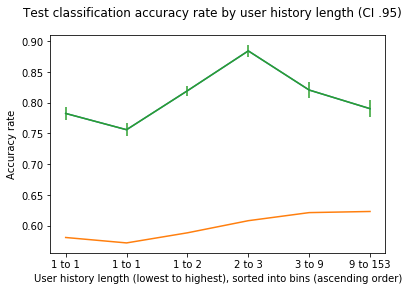

In [6]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
eval_tools.plot_cis(bin_names, graph_results, priors_list)

# NLP only LSTM


In [7]:
%%capture
outfile = 'nlp_only_lstm_results.npy'

acc, auc, f1, precision,\
recall, bin_names, graph_results, priors_list = run_tests(outfile, training_data, test_data,
                                                          hist_len_data, nlp_lstm_hyperparams,
                                                          is_lstm = True, is_multimodal = False)

Acc: 0.7916604244694132
AUC: 0.8327529338131748
F1: 0.8636522423611701
Precision: 0.8220752303733928
Recall: 0.9096729776247847


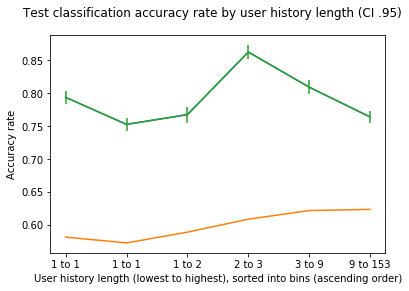

In [8]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
eval_tools.plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [9]:
GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# multimodal with histories

In [10]:
# retrieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# class labels
y_train = torch.Tensor(np.load(GLOVE_DIR + 'y_train.npy'))
y_test= torch.Tensor(np.load(GLOVE_DIR + 'y_test.npy'))

# load features
# img
X_histories_train_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_train.npy')
X_histories_test_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_test.npy')

X_labeled_train_img = np.load(NPY_INPUT_DIR + 'images_nohistories_train.npy')
X_labeled_test_img = np.load(NPY_INPUT_DIR + 'images_nohistories_test.npy')

# lang
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')



X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')


scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

scaler5 = StandardScaler()
scaler6 = StandardScaler()


X_histories_train_img_norm = scaler5.fit_transform(X_histories_train_img)
X_histories_test_img_norm  = scaler5.transform(X_histories_test_img)
X_labeled_train_img_norm = scaler5.fit_transform(X_labeled_train_img)
X_labeled_test_img_norm  = scaler5.transform(X_labeled_test_img)
        
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

In [11]:
# merge data

X_train = torch.Tensor(np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm,
                          X_histories_train_img_norm, X_labeled_train_img_norm),
                         axis = 1))
X_test = torch.Tensor(np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm,
                         X_histories_test_img_norm, X_labeled_test_img_norm),
                        axis = 1))

In [12]:
training_data = [X_train, None, y_train] # Nones for argument order padding
test_data = [X_test, None, y_test]
hist_len_data = [X_hist_len_test, y_train.numpy()]
outfile = 'multimodal_MLP_hist_results.npy'

In [13]:
%%capture
acc, auc, f1, precision,\
recall, bin_names, graph_results, priors_list = run_tests(outfile, training_data, test_data,
                                                          hist_len_data, multimodal_mlp_hist_hyperparams,
                                                          is_lstm = False, is_multimodal = True)

Acc: 0.8156803995006241
AUC: 0.8585887967454233
F1: 0.8779782820421628
Precision: 0.84453323620062
Recall: 0.9142168674698793


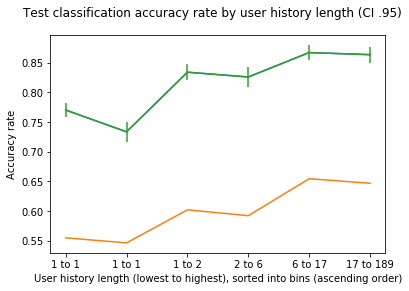

In [14]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
eval_tools.plot_cis(bin_names, graph_results, priors_list)

# NLP only with histories

In [15]:
# merge data

X_train = torch.Tensor(np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1))
X_test = torch.Tensor(np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1))

In [16]:
training_data = [X_train, None, y_train] # Nones for argument order padding
test_data = [X_test, None, y_test]
hist_len_data = [X_hist_len_test, y_train.numpy()]
outfile = 'nlp_MLP_hist_results.npy'

In [17]:
%%capture
acc, auc, f1, precision,\
recall, bin_names, graph_results, priors_list = run_tests(outfile, training_data, test_data,
                                                          hist_len_data, nlp_mlp_hist_hyperparams,
                                                          is_lstm = False, is_multimodal = False)

Acc: 0.7993008739076153
AUC: 0.8396848693475201
F1: 0.8702365054946418
Precision: 0.81944636701115
Recall: 0.9278485370051635


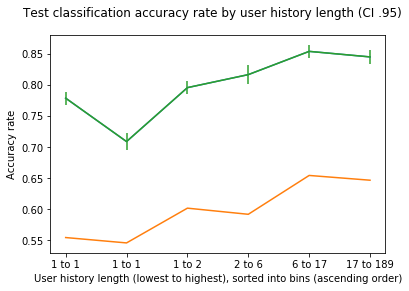

In [18]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
eval_tools.plot_cis(bin_names, graph_results, priors_list)

# Multimodal without histories

In [19]:
# merge data

X_train = torch.Tensor(np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                        X_labeled_train_img_norm),
                         axis = 1))
X_test = torch.Tensor(np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                        X_labeled_test_img_norm),
                        axis = 1))

In [20]:
training_data = [X_train, None, y_train] # Nones for argument order padding
test_data = [X_test, None, y_test]
hist_len_data = [X_hist_len_test, y_train.numpy()]
outfile = 'multimodal_MLP_no_hist_results.npy'

In [21]:
%%capture
acc, auc, f1, precision,\
recall, bin_names, graph_results, priors_list = run_tests(outfile, training_data, test_data,
                                                          hist_len_data, multimodal_mlp_no_hist_hyperparams,
                                                          is_lstm = False, is_multimodal = True)

Acc: 0.8214232209737825
AUC: 0.8708867156939448
F1: 0.8832966951919841
Precision: 0.840319955701364
Recall: 0.9314285714285713


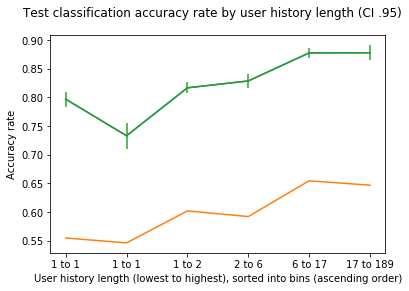

In [22]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
eval_tools.plot_cis(bin_names, graph_results, priors_list)

# nlp only without histories


In [23]:
# merge data

X_train = torch.Tensor(np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1))
X_test = torch.Tensor(np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1))

In [24]:
training_data = [X_train, None, y_train] # Nones for argument order padding
test_data = [X_test, None, y_test]
hist_len_data = [X_hist_len_test, y_train.numpy()]
outfile = 'nlp_MLP_no_hist_results.npy'

In [25]:
%%capture
acc, auc, f1, precision,\
recall, bin_names, graph_results, priors_list = run_tests(outfile, training_data, test_data,
                                                          hist_len_data, nlp_mlp_no_hist_hyperparams,
                                                          is_lstm = False, is_multimodal = False)

Acc: 0.7953058676654183
AUC: 0.8384950711938665
F1: 0.8675308572277507
Precision: 0.8177056225105129
Recall: 0.9241308089500859


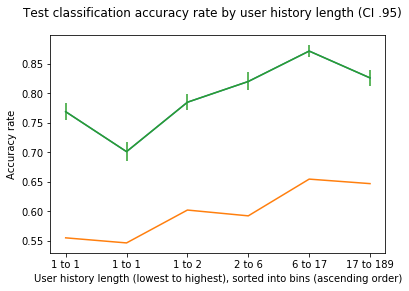

In [26]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
eval_tools.plot_cis(bin_names, graph_results, priors_list)

